In [27]:
from __future__ import annotations
import re
from pathlib import Path
from functools import lru_cache
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Root repo and expected subpaths for bins, panels, and CSVVs.
BASE = Path("/user/ab5405/summeraliaclimate")
BINS_DIR   = BASE / "code/regressions/bins"                     # gmfd_bins_labels.*
PANELS_DIR = BASE / "code/regressions/prep_panels"              # global_mortality_panel_public_*.dta
CSVV_DIR   = BASE / "code/regressions/output/age_spec_interacted_csvv"  # agespec_interaction_response_spec2_*.csvv

PRODUCTS = ["ERA5_025", "GMFD", "MERRA2", "JRA_3Q"]

YEAR_REF = 2010

#Draw the 65+ block out of the age×poly×covariate tensor in the CSVV
AGE_LABEL = "65+"
AGE_IDX = 2 

#temperature plotting domain & normalization window
TMIN, TMAX = -15.0, 45.0
SLICE_MIN, SLICE_MAX = 10.0, 25.0   # baseline window to subtract min() over [10,25]

#Monte Carlo setup for uncertainty bands
N_DRAWS = 800
RNG = np.random.default_rng(123)

#Presentation style per product
PROD_STYLE = {
    "ERA5_025": dict(label="ERA5-025", color="red"),
    "GMFD":     dict(label="GMFD",     color="blue"),
    "MERRA2":   dict(label="MERRA-2",  color="green"),
    "JRA_3Q":   dict(label="JRA-3Q",   color="orange"),
}

#Panel layout ordering
INCS = ["high", "mid", "low"]
REGS = ["cold", "temperate", "hot"]

# Toggle: make LR constant within a climate *column* for a given product.
# If True, curves within the same climate region differ only due to income (logy)
# and stochastic variation; LR is column-shared.
USE_COLUMN_SHARED_LR = True


In [28]:
#create a population weighted mean with weight w of variable s, ignoring nans. Applied to population weight terciles 
def wavg(series: pd.Series, weights: pd.Series) -> float:
    s = series.to_numpy(float)
    w = weights.to_numpy(float)
    m = np.isfinite(s) & np.isfinite(w) & (w > 0)
    return float(np.average(s[m], weights=w[m])) if m.any() else np.nan

def weighted_terciles_from_values(x: pd.Series, w: pd.Series) -> pd.Series:
    """Compute *global* (population-weighted) terciles; returns labels {low, mid, high}.
    Not used in the main flow because we import bins from gmfd_bins_labels.*,
    but included here for reference / reproducibility.
    """
    order = np.argsort(x.values)
    xs, ws = x.values[order], w.values[order]
    cdf = np.cumsum(ws) / ws.sum()
    t1 = xs[np.searchsorted(cdf, 1/3)]
    t2 = xs[np.searchsorted(cdf, 2/3)]
    return pd.cut(x, [-np.inf, t1, t2, np.inf], labels=["low","mid","high"], include_lowest=True)


def _lr_colname(cols, product: str) -> str:
    for cand in (f"lr_tavg_{product}_adm1_avg", f"lr_tavg_{product.replace('_','-')}_adm1_avg"):
        if cand in cols:
            return cand
    # Final fallback: first LR column matching the pattern
    for c in cols:
        if re.fullmatch(r"lr_tavg_[^,]+_adm1_avg", c):
            return c
    raise KeyError(f"No lr_tavg_*_adm1_avg column found for {product}")



In [29]:
def _read_gamma_and_vcv(csvv_path: Path):
    txt = Path(csvv_path).read_text()
    _FLOAT = r"[-+]?(?:\d+\.?\d*|\.\d+)(?:[Ee][-+]?\d+)?"
    g_block = re.search(r"\bgamma\s*(.*?)\bgammavcv\b", txt, flags=re.S|re.I)
    v_block = re.search(r"\bgammavcv\b(.*)\Z",           txt, flags=re.S|re.I)
    if not g_block or not v_block:
        raise ValueError(f"Could not find gamma / gammavcv in {csvv_path}")
    g = [float(x) for x in re.findall(_FLOAT, g_block.group(1))]
    v = [float(x) for x in re.findall(_FLOAT, v_block.group(1))]
    gamma    = np.array(g[:36], float).reshape(3,4,3)     # [age, poly, cov(1,LR,logy)]
    gammavcv = np.array(v[:36*36], float).reshape(36,36)
    return gamma, gammavcv

In [30]:
def build_gmfd_bins_from_panel(
    panel_path: str | Path,
    year: int = 2010,
    weight_age: str | None = None,   # e.g. "65+" to weight by that age only; None = total pop
) -> pd.DataFrame:
    """
    Rebuild GMFD-based 3×3 bins using weighted_terciles_from_values.
    - Income terciles: low/mid/high (from loggdppc_adm1_avg)
    - Temp terciles:   cold/temperate/hot (mapped from low/mid/high on LR)
    Returns a DataFrame: [adm2_id, income_terc, temp_region]
    """
    panel_path = Path(panel_path)
    use = ["adm2_id","year","agegroup","population","loggdppc_adm1_avg","lr_tavg_GMFD_adm1_avg"]

    #keep only 2010 entries
    df = pd.read_stata(str(panel_path), columns=use, convert_categoricals=False)
    df = df.loc[df["year"] == year].copy()
    df["adm2_id"] = df["adm2_id"].astype(str)

    # weights: either total pop or age-specific pop, depending on spec at the beginning 
    if weight_age is not None:
        dfw = df.loc[df["agegroup"] == weight_age].copy()
    else:
        dfw = df

    # collapse to one row per ADM2 (for population, sum across ages, take the first gdp and lr values (as lr temp
    # is computed for adm1 regions))

    g_pop = (dfw.groupby("adm2_id", as_index=False).agg(pop=("population","sum")))
    g_vals = (df.groupby("adm2_id", as_index=False).agg(logy=("loggdppc_adm1_avg","first"), lr=("lr_tavg_GMFD_adm1_avg","first")))
    g = g_pop.merge(g_vals, on="adm2_id", how="inner").dropna(subset=["pop","logy","lr"])

    # compute population terciles from the function above for income and temp, population weighted from series above. 
    inc_cats = weighted_terciles_from_values(g["logy"], g["pop"])            # low/mid/high
    tmp_cats_raw = weighted_terciles_from_values(g["lr"], g["pop"])          # low/mid/high
    # map low/mid/high to cold/temperate/hot for temperature
    map_tmp = {"low":"cold", "mid":"temperate", "high":"hot"}
    tmp_cats = tmp_cats_raw.astype(str).map(map_tmp)

    bins_df = pd.DataFrame({
        "adm2_id": g["adm2_id"],
        "income_terc": inc_cats.astype(str),
        "temp_region": tmp_cats.astype(str),
    })
    return bins_df


def save_bins(bins_df: pd.DataFrame, out_csv: str | Path, out_parquet: str | Path | None = None):
    out_csv = Path(out_csv)
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    bins_df.to_csv(out_csv, index=False)
    if out_parquet:
        out_parquet = Path(out_parquet)
        out_parquet.parent.mkdir(parents=True, exist_ok=True)
        try:
            bins_df.to_parquet(out_parquet, index=False)
        except Exception as e:
            print(f"[warn] parquet save skipped: {e}")

In [12]:
#with those labels, return a clean dataframe with one row per adm2 region
def load_bins_labels(bins_dir: Path) -> pd.DataFrame:
    # Expect gmfd_bins_labels.{csv|parquet} with columns: adm2_id, income_terc, temp_region (strings)
    csv_path = bins_dir / "gmfd_bins_labels.csv"
    pq_path  = bins_dir / "gmfd_bins_labels.parquet"
    usecols  = ["adm2_id","income_terc","temp_region"]
    if csv_path.exists():
        out = pd.read_csv(csv_path, usecols=usecols, dtype={"adm2_id":"string"})
    elif pq_path.exists():
        out = pd.read_parquet(pq_path, columns=usecols)
    else:
        raise FileNotFoundError("gmfd_bins_labels.{csv|parquet} not found")
    out["adm2_id"] = out["adm2_id"].astype(str)
    out["income_terc"] = out["income_terc"].astype(str)
    out["temp_region"] = out["temp_region"].astype(str)
    return out

#makes a tuple key from the three columns in the load_bins_labels dataframe
def build_cell_index(labels: pd.DataFrame) -> dict[tuple[str,str], set[str]]:
    d = labels[["adm2_id","income_terc","temp_region"]].copy()
    d["cell"] = list(zip(d["income_terc"], d["temp_region"]))
    return {cell: set(g["adm2_id"]) for cell, g in d.groupby("cell")}

In [31]:
#Return (lr_mean, loginc_mean) as *weighted averages across selected ADM2s*.
def cell_means_streaming(
    dta_path,
    product,
    ids_adm2,
    *,
    year=2010,
    weight_base="total",   # "total" or "age"
    age_label="65+",
    loginc_col="loggdppc_adm1_avg",
    lr_col=None,
    chunksize=200_000,
):

    if lr_col is None:
        # pd.read_stata(..., iterator=True, chunksize=1) yields an iterator of DataFrames
        #take the first mini-chunk and grab its .columns
        cols0 = next(iter(pd.read_stata(str(dta_path), iterator=True, chunksize=1))).columns
        lr_col = _lr_colname(cols0, product)
        
    # Only load the columns we actually need
    need = ["adm2_id", "year", "population", loginc_col, lr_col]
    if weight_base == "age":
        need += ["agegroup"]

    #Create a chunked Stata reader over the requested columns.
    rdr = pd.read_stata(str(dta_path), iterator=True, chunksize=chunksize, columns=need)

    #Running weighted sums (accumulators)
    w_sum = 0.0        # total weight (population)
    wlr_sum = 0.0      # sum of (weight * lr)
    wlog_sum = 0.0     # sum of (weight * log-income)

    # Normalize the target ADM2 IDs to strings and put in a set for fast membership checks.
    ids_adm2 = set(map(str, ids_adm2))

    for ch in rdr:
        ch = ch.copy()
        ch["adm2_id"] = ch["adm2_id"].astype(str)

        # Filter to target year and ADM2s in panel
        ch = ch[(ch["year"] == year) & (ch["adm2_id"].isin(ids_adm2))]
        if ch.empty:
            continue

        # Choose the weighting base:
        # - "age": restrict to the specified age group and use its population
        # - "total": sum the populations across all age rows for that ADM2
        if weight_base == "age":
            ch = ch[ch["agegroup"] == age_label]
            if ch.empty:
                continue

            # Collapse to one row per adm2_id:
            #   - pop: sum weights within ADM2
            #   - lr/logy: take 'first' because ADM2 attributes are constant within ADM2 by design
            sub = (ch.groupby("adm2_id", as_index=False).agg(pop=("population", "sum"), lr=(lr_col, "first"),
                          logy=(loginc_col, "first")))
        else:  # "total"
            # Same collapse, but using *all* ages as weights (summing population)
            sub = (ch.groupby("adm2_id", as_index=False)
                     .agg(pop=("population", "sum"), lr=(lr_col, "first"),
                          logy=(loginc_col, "first")))

        # Drop any ADM2s with missing weight or attributes
        sub = sub.dropna(subset=["pop", "lr", "logy"])
        if sub.empty:
            continue

        w  = sub["pop"].to_numpy("float64")
        lr = sub["lr"].to_numpy("float64")
        lg = sub["logy"].to_numpy("float64")

        # Keep only finite values and strictly positive weights
        m = np.isfinite(w) & np.isfinite(lr) & np.isfinite(lg) & (w > 0)
        if not m.any():
            continue

        #Accumulate sums for the weighted means
        w   = w[m]; lr = lr[m]; lg = lg[m]
        w_sum   += float(w.sum())
        wlr_sum += float((w * lr).sum())
        wlog_sum+= float((w * lg).sum())
        
    if w_sum == 0.0:
        raise ValueError("No rows matched after filtering/collapse.")

    #Weighted means
    return wlr_sum / w_sum, wlog_sum / w_sum


In [32]:
def _mc_bands_for_cell(T, slice_min, slice_max, lr_tavg, loggdppc, gamma_mean, gamma_vcv,
                       age_index=AGE_IDX, n_draws=N_DRAWS, rng=RNG):
    g_flat = gamma_mean.reshape(-1)
    draws = rng.multivariate_normal(g_flat, gamma_vcv, size=n_draws).reshape(n_draws, 3, 4, 3)
    # Effective coefficients for this (lr, logy)

    b1 = draws[:, age_index, 0, 0] + draws[:, age_index, 0, 1]*lr_tavg + draws[:, age_index, 0, 2]*loggdppc
    b2 = draws[:, age_index, 1, 0] + draws[:, age_index, 1, 1]*lr_tavg + draws[:, age_index, 1, 2]*loggdppc
    b3 = draws[:, age_index, 2, 0] + draws[:, age_index, 2, 1]*lr_tavg + draws[:, age_index, 2, 2]*loggdppc
    b4 = draws[:, age_index, 3, 0] + draws[:, age_index, 3, 1]*lr_tavg + draws[:, age_index, 3, 2]*loggdppc
    eff = np.column_stack([b1, b2, b3, b4])                            # (n_draws, 4)
    Tpow = np.vstack([T, T**2, T**3, T**4])                            # (4, len(T))
    y_raw = eff @ Tpow                                                 # (n_draws, len(T))

    # Normalize at min over [slice_min, slice_max]
    win = (T >= slice_min) & (T <= slice_max)
    base = np.nanmin(y_raw[:, win], axis=1)
    y = y_raw - base[:, None]

    y_mean = np.nanmean(y, axis=0)
    y_lo, y_hi = np.nanpercentile(y, [5, 95], axis=0)
    return y_mean, y_lo, y_hi

In [33]:
# These functions build the single source of terciles for LR and log-income
# used in plotting for all products.

def build_reference_from_GMFD(dta_base: Path,
                              idx: dict[tuple[str,str], set[str]],
                              *,
                              year: int = YEAR_REF) -> tuple[pd.DataFrame, dict[str, float]]:
    """Compute GMFD-based reference values:

    Returns
    -------
    ref_cell_means : DataFrame with columns [income_terc, temp_region, lr_mean, loginc]
        Population-weighted per-cell LR and log-income computed from the GMFD panel in `year`.
    ref_region_lr : dict[temp_region → lr_mean]
        Column-shared LR per climate region, pooling over the income terciles (GMFD-only).
    """
    gmfd_path = dta_base / "global_mortality_panel_public_GMFD.dta"

    #Per-region LR (column-shared): union of ADM2s across income terciles
    ref_region_lr: dict[str, float] = {}
    for reg in REGS:
        ids_union = set().union(*(idx.get((inc, reg), set()) for inc in INCS))
        if not ids_union:
            continue
        lr_mean_reg, _ = cell_means_streaming(gmfd_path, "GMFD", ids_union, year=year)
        ref_region_lr[reg] = float(lr_mean_reg)

        
    #Per-cell LR and log-income (GMFD-only)
    rows = []
    for inc in INCS:
        for reg in REGS:
            ids = idx.get((inc, reg), set())
            if not ids:
                continue
            lr_mean, log_mean = cell_means_streaming(gmfd_path, "GMFD", ids, year=year)
            rows.append([inc, reg, float(lr_mean), float(log_mean)])

    ref_cell_means = pd.DataFrame(rows, columns=["income_terc","temp_region","lr_mean","loginc"])
    return ref_cell_means, ref_region_lr

In [34]:
def plot_overlay_3x3(ref_cell_means: pd.DataFrame,
                     ref_region_lr: dict[str,float],
                     gamma_cache: dict[str, tuple[np.ndarray,np.ndarray]],
                     *,
                     use_column_shared_lr: bool = True):

    T = np.linspace(TMIN, TMAX, 800)
    fig, axes = plt.subplots(3, 3, figsize=(12.5, 9.5), sharex=True, sharey=True)
    legend_handles = []
    for i, inc in enumerate(INCS):
        for j, reg in enumerate(REGS):
            ax = axes[i, j]
            # Visual baseline window and zero line
            ax.axvspan(SLICE_MIN, SLICE_MAX, color="0.9", alpha=0.25, zorder=0)
            ax.axhline(0, color="k", ls="--", lw=1, zorder=1)

            # Pull GMFD-referenced per-cell values (same for all products)
            r = ref_cell_means[(ref_cell_means.income_terc==inc) & (ref_cell_means.temp_region==reg)]
            if r.empty:
                continue
            row = r.iloc[0]

            # LR for plotting: either column-shared (GMFD-only) or per-cell (GMFD-only)
            lr_for_panel = ref_region_lr[reg] if use_column_shared_lr else float(row.lr_mean)
            # Per-cell income is always from GMFD reference now
            loginc_for_panel = float(row.loginc)

            for prod in PRODUCTS:
                gm, gv = gamma_cache[prod]
                y_mean, y_lo, y_hi = _mc_bands_for_cell(
                    T, SLICE_MIN, SLICE_MAX,
                    lr_tavg=lr_for_panel,
                    loggdppc=loginc_for_panel,
                    gamma_mean=gm, gamma_vcv=gv,
                    age_index=AGE_IDX, n_draws=N_DRAWS, rng=RNG
                )
                style = PROD_STYLE[prod]
                (ln,) = ax.plot(T, y_mean, lw=2.0, **style, zorder=3)
                ax.fill_between(T, y_lo, y_hi, alpha=0.10, color=style["color"], linewidth=0, zorder=2)
                if i==0 and j==0:
                    legend_handles.append(ln)

            if i == 0: ax.set_title(reg.capitalize())
            if j == 0: ax.set_ylabel(f"{inc.capitalize()} income\nΔ deaths per 100k")

    for ax in axes[-1, :]:
        ax.set_xlabel("Temperature [°C]")
    for ax in axes.flat:
        ax.set_ylim(-20, 220)
        ax.set_yticks([0,50,100,150,200])
        ax.tick_params(labelsize=9)

    fig.subplots_adjust(top=0.84)
    fig.legend(handles=legend_handles,
               labels=[PROD_STYLE[p]["label"] for p in PRODUCTS],
               loc="upper center", ncol=len(PRODUCTS), frameon=True, fontsize=10)
    fig.suptitle(
        "All reanalyses — Age >64 response by income tercile × climate region (Spec 2)\n"
        "MC bands; baseline = min over 10–25°C",
        y=0.93
    )
    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()

            

In [35]:
def sanity_population_shares(bins: pd.DataFrame, panel2010: pd.DataFrame):
    """Print population shares by income tercile and temp region for 2010.
    Uses GMFD panel only to mirror bin construction.
    """
    use = ["adm2_id","year","agegroup","population","lr_tavg_GMFD_adm1_avg","loggdppc_adm1_avg"]
    df2010 = panel2010[use].copy()
    df2010 = df2010[df2010["year"]==YEAR_REF].copy()
    df2010["adm2_id"] = df2010["adm2_id"].astype(str)

    # Collapse to ADM2 totals (all ages), keep ADM2-level LR/log-income
    adm2_agg = (df2010
        .sort_values(["adm2_id","agegroup"])
        .groupby("adm2_id", as_index=False)
        .agg(pop2010=("population","sum"),
             lr=("lr_tavg_GMFD_adm1_avg","first"),
             logy=("loggdppc_adm1_avg","first"))
        .dropna(subset=["pop2010","lr","logy"]))

    merged = bins.merge(adm2_agg, on="adm2_id", how="left")

    inc_share = (merged.groupby("income_terc")["pop2010"].sum() / merged["pop2010"].sum() * 100).round(1)
    tmp_share = (merged.groupby("temp_region")["pop2010"].sum() / merged["pop2010"].sum() * 100).round(1)
    print("\n[Sanity] Population shares by tercile (%):")
    print("Income:", inc_share.to_dict())
    print("Temp  :", tmp_share.to_dict())


def sanity_monotonic_means(bins: pd.DataFrame, panel2010: pd.DataFrame):
    use = ["adm2_id","year","agegroup","population","lr_tavg_GMFD_adm1_avg","loggdppc_adm1_avg"]
    df2010 = panel2010[use].copy()
    df2010 = df2010[df2010["year"]==YEAR_REF].copy()
    df2010["adm2_id"] = df2010["adm2_id"].astype(str)

    # attach bins
    merged = df2010.merge(bins, on="adm2_id", how="left")
    tab = (merged.groupby(["income_terc","temp_region"])
           .apply(lambda g: pd.Series({
               "lr_mean"  : wavg(g["lr_tavg_GMFD_adm1_avg"], g["population"]),
               "logy_mean": wavg(g["loggdppc_adm1_avg"],     g["population"])
           }))
           .reset_index())

    print("\n[Sanity] Mean LR (°C) by cell:")
    print(tab.pivot(index="income_terc", columns="temp_region", values="lr_mean").round(1))
    print("\n[Sanity] Mean log-income by cell:")
    print(tab.pivot(index="income_terc", columns="temp_region", values="logy_mean").round(2))

    # Monotone checks (tolerant).
    for inc in INCS:
        row = tab[tab["income_terc"]==inc].set_index("temp_region").loc[REGS, "lr_mean"].to_numpy()
        assert np.all(np.diff(row) >= -1e-6), f"Non-monotone LR across regions for income={inc}"

    for reg in REGS:
        col = tab[tab["temp_region"]==reg].set_index("income_terc").loc[["low","mid","high"], "logy_mean"].to_numpy()
        assert np.all(np.diff(col) >= -1e-6), f"Non-monotone log-income across income terciles for region={reg}"


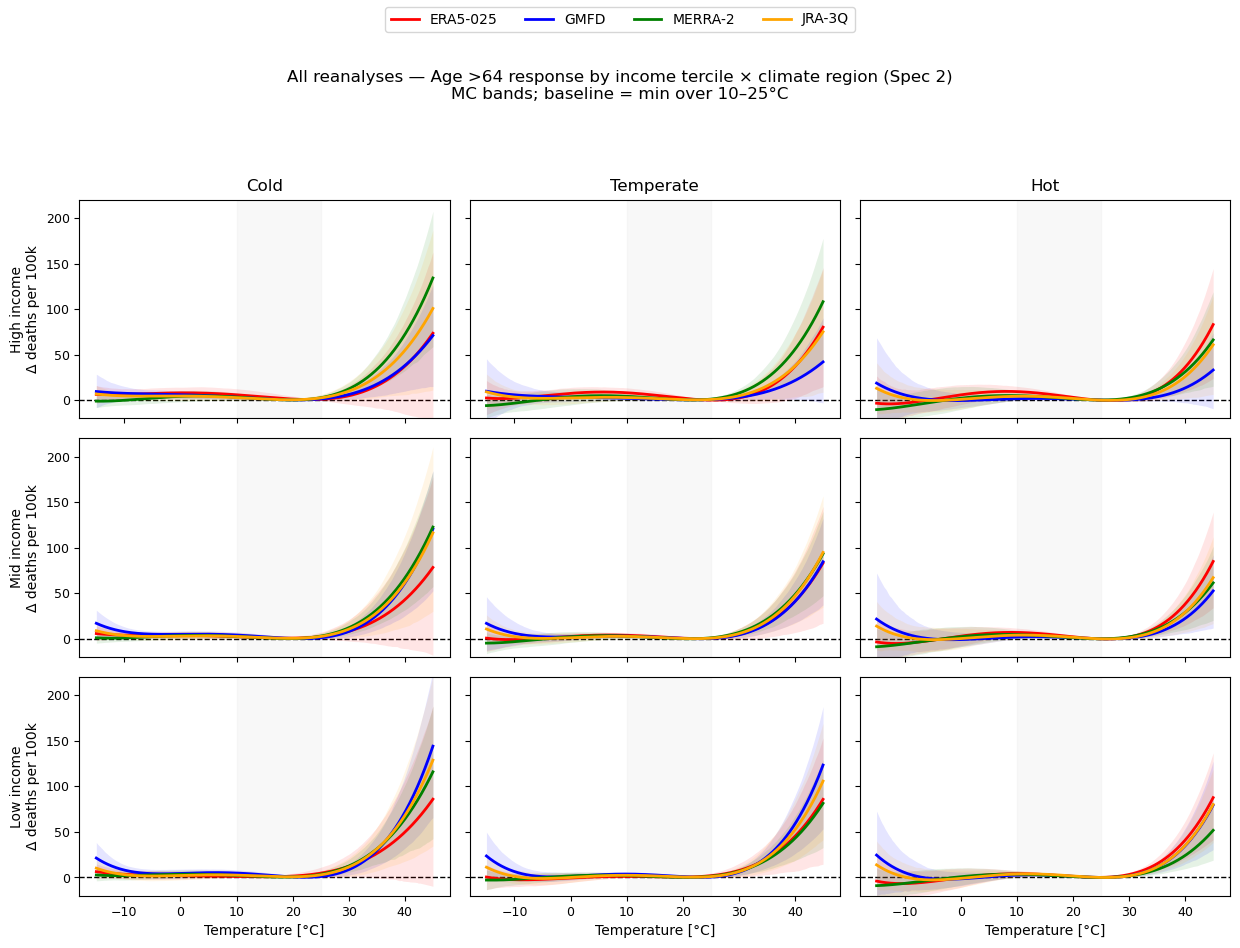


[Sanity] Population shares by tercile (%):
Income: {'high': 33.0, 'low': 33.5, 'mid': 33.5}
Temp  : {'cold': 33.4, 'hot': 32.9, 'temperate': 33.7}

[Sanity] Mean LR (°C) by cell:
temp_region  cold   hot  temperate
income_terc                       
high          8.5  26.3       12.5
low           8.5  19.3       16.8
mid           8.4  22.6       14.7

[Sanity] Mean log-income by cell:
temp_region   cold   hot  temperate
income_terc                        
high         10.36  9.99      10.34
low           9.17  9.33       9.12
mid           9.62  9.68       9.69


/tmp/8415216.1.debian.q/ipykernel_51561/3484836980.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [36]:
def main():
    #Load GMFD bins (2010) — lock uniform cell membership
    bins = load_bins_labels(BINS_DIR)
    idx = build_cell_index(bins)

    #Build GMFD-based reference inputs (per-cell log-income & LR; per-region LR)
    REF_CELL_MEANS, REF_REGION_LR = build_reference_from_GMFD(PANELS_DIR, idx, year=YEAR_REF)

    #Load CSVVs (gamma + VCV) per product
    gamma_cache = {}
    for prod in PRODUCTS:
        csvv_path = CSVV_DIR / f"agespec_interaction_response_spec2_{prod}.csvv"
        gm, gv = _read_gamma_and_vcv(csvv_path)
        gamma_cache[prod] = (gm, gv)

    #Plot overlay (Figure 1) using GMFD-referenced covariates for ALL products
    plot_overlay_3x3(REF_CELL_MEANS, REF_REGION_LR, gamma_cache,
                     use_column_shared_lr=USE_COLUMN_SHARED_LR)

    #Sanity checks using GMFD panel (mirrors bin vintage)
    gmfd_panel_path = PANELS_DIR / "global_mortality_panel_public_GMFD.dta"
    gmfd2010 = pd.read_stata(str(gmfd_panel_path), iterator=False, convert_categoricals=False)
    sanity_population_shares(bins, gmfd2010)
    sanity_monotonic_means(bins, gmfd2010)

if __name__ == "__main__":
    main()


[MERGE] missing geometry: 0 / 34012


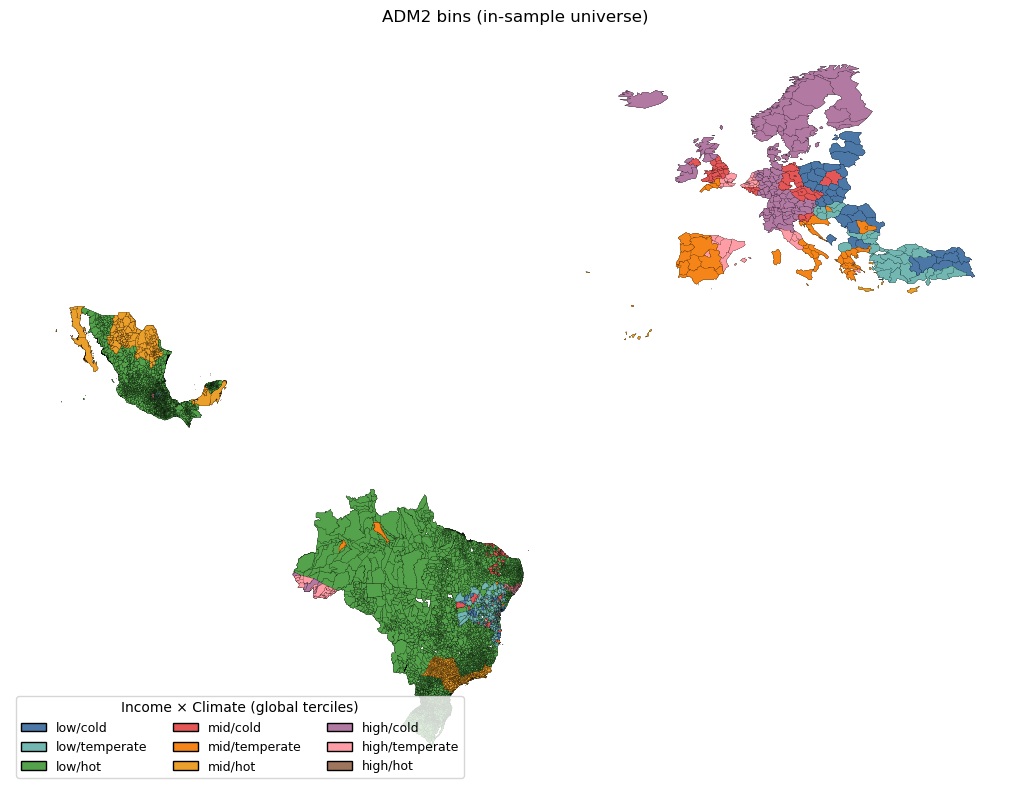

In [26]:
# Map bins using ONLY the insample shapefile (no panel load)
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt, matplotlib.patches as mpatches
from pathlib import Path

BASE = Path("/user/ab5405/summeraliaclimate")
BINS_CSV = BASE / "code/regressions/bins/gmfd_bins_labels_fixed.csv"
SHP_PATH = Path("/shared/share_hle/data/1_estimation/3_regions/insample_shp/mortality_insample_world.shp")

INCS = ["low","mid","high"]
REGS = ["cold","temperate","hot"]
CAT_COLORS = {
    "low/cold": "#4C78A8", "low/temperate": "#72B7B2", "low/hot": "#54A24B",
    "mid/cold": "#E45756", "mid/temperate": "#F58518", "mid/hot": "#ECA02C",
    "high/cold":"#B279A2", "high/temperate":"#FF9DA6", "high/hot":"#9D755D",
}

#Load bins
bins = pd.read_csv(BINS_CSV, dtype={"adm2_id":"string"}).dropna(subset=["adm2_id"]).copy()
bins["adm2_id"] = bins["adm2_id"].astype(str).str.strip()

#Load insample shapefile
cols_needed = ["iso","adm1_id","adm2_id","geometry"]
g = gpd.read_file(SHP_PATH)[cols_needed].copy()
g["adm2_id"] = g["adm2_id"].astype(str).str.strip()

#if adm2_id isn’t unique in shapes:
if g["adm2_id"].duplicated().any():
    # keep first; or you could dissolve by adm2_id if you prefer
    g = g.drop_duplicates(subset=["adm2_id"], keep="first")

#Merge bins; shapes on adm2_id (no panel involved)
merged = bins.merge(g, on="adm2_id", how="left")
miss = merged["geometry"].isna().sum()
print(f"[MERGE] missing geometry: {miss} / {len(merged)}")
if miss:
    print(merged.loc[merged["geometry"].isna(), "adm2_id"].head(10).tolist())

#Build category & color
merged["cat"] = merged["income_terc"].astype(str) + "/" + merged["temp_region"].astype(str)
merged["cat"] = pd.Categorical(merged["cat"],
                               categories=[f"{i}/{r}" for i in INCS for r in REGS],
                               ordered=True)
merged["facecolor"] = merged["cat"].map(CAT_COLORS)

gdf_bins = gpd.GeoDataFrame(merged.dropna(subset=["geometry"]),
                            geometry="geometry", crs=g.crs)

#Single map
def plot_bins_map(gdf):
    fig, ax = plt.subplots(1,1, figsize=(10.5,8))
    gdf.plot(ax=ax, color=gdf["facecolor"], edgecolor="black", linewidth=0.1)
    ax.set_axis_off()
    patches = [mpatches.Patch(facecolor=CAT_COLORS[k], edgecolor="black", label=k)
               for k in CAT_COLORS]
    ax.legend(handles=patches, title="Income × Climate (global terciles)",
              loc="lower left", frameon=True, ncol=3, fontsize=9)
    ax.set_title("ADM2 bins (in-sample universe)")
    plt.tight_layout(); plt.show()

plot_bins_map(gdf_bins)
